# Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
pd.set_option('display.max_colwidth', None)
from tqdm.auto import tqdm
import pickle 
import random
import re
import math
import cv2
import glob
import os
import json
import collections
from collections import Counter

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

In [2]:
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

## Define parameter

In [3]:
batch_size = 64
embedding_size = 1280

# Dataset Uploading

In [4]:
train_img_path = "/kaggle/input/ktvic-dataset/ktvic/images/train"
test_img_path = "/kaggle/input/ktvic-dataset/ktvic/images/test"

In [5]:
def change_image_extensions(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpeg', '.png')):
            base_name, extension = os.path.splitext(filename)
            new_filename = base_name + '.jpg'
            os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))
            print(f"Đã đổi tên {filename} thành {new_filename}")

In [6]:
change_image_extensions(train_img_path)
change_image_extensions(test_img_path)

In [7]:
annotation_train_path = '/kaggle/input/ktvic-dataset/ktvic/annotations/train_caption.json'
annotation_test_path = '/kaggle/input/ktvic-dataset/ktvic/annotations/test_caption.json'

with open(annotation_train_path, 'r') as f:
    annotations_train = json.load(f)

with open(annotation_test_path, 'r') as f:
    annotations_test = json.load(f)

In [8]:
annotations_train['images'][:1]

[{'id': 2, 'filename': '00000000002.jpg'}]

In [9]:
annotations_train['annotations'][:1]

[{'id': 0,
  'image_id': 2,
  'caption': 'ba chiếc thuyền đang di chuyển ở trên con sông',
  'segment_caption': 'ba chiếc thuyền đang di_chuyển ở trên con sông'}]

# Group all captions together having the same image ID.


In [10]:
# Group all captions together having the same image ID.

# ‘image_path_to_caption’, where the keys are the file paths to the images and the values are lists of captions for each image
img_path_to_caption_train = collections.defaultdict(list)

# Iterates through the ‘annotations['annotations']’ list, which contains information about the captions for each image. For each caption, 
# the code creates a string caption that starts with the special token ‘"<start>"’ and ends with the special token ‘"<end>"’.
for annotation in annotations_train['annotations']:
    caption = f"<start> {annotation['caption']} <end>"
    img_path = train_img_path + '/%011d.jpg' % (annotation['image_id'])
    img_path_to_caption_train[img_path].append(caption)

In [11]:
img_path_to_caption_test = collections.defaultdict(list)
for annotation in annotations_test['annotations']:
    caption = f"<start> {annotation['caption']} <end>"
    img_path = test_img_path + '/%011d.jpg' % (annotation['image_id'])
    img_path_to_caption_test[img_path].append(caption)

# Convert to dataframe

In [12]:
df_train = (pd.DataFrame.from_dict(img_path_to_caption_train, orient='index').T.melt(var_name='image', value_name='caption').dropna(subset=['caption'])) 
df_train.head()

,image,caption
0,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000002.jpg,<start> ba chiếc thuyền đang di chuyển ở trên con sông <end>
1,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000002.jpg,<start> có ba con thuyền đang di chuyển trên con sông <end>
2,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000002.jpg,<start> trên dòng sông có ba con thuyền đang di chuyển <end>
3,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000002.jpg,<start> ba con thuyền đang di chuyển bên một cánh đồng lúa <end>
4,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000002.jpg,<start> ba chiếc thuyền đang chuyển động trên một con sông <end>


In [13]:
df_train.head(10)

,image,caption
0,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000002.jpg,<start> ba chiếc thuyền đang di chuyển ở trên con sông <end>
1,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000002.jpg,<start> có ba con thuyền đang di chuyển trên con sông <end>
2,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000002.jpg,<start> trên dòng sông có ba con thuyền đang di chuyển <end>
3,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000002.jpg,<start> ba con thuyền đang di chuyển bên một cánh đồng lúa <end>
4,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000002.jpg,<start> ba chiếc thuyền đang chuyển động trên một con sông <end>
5,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> người phụ nữ đang cõng một đứa trẻ trên lưng <end>
6,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> ở trên lưng người phụ nữ có một đứa trẻ <end>
7,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> người phụ nữ cõng một đứa bé ở trên lưng <end>
8,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> có một đứa bé trên lưng của người phụ nữ <end>
9,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> có một đứa trẻ ở trên lưng của một người phụ nữ <end>


In [14]:
train_unique = df_train['image'].unique()

In [15]:
train_unique

array(['/kaggle/input/ktvic-dataset/ktvic/images/train/00000000002.jpg',
       '/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg',
       '/kaggle/input/ktvic-dataset/ktvic/images/train/00000000004.jpg',
       ...,
       '/kaggle/input/ktvic-dataset/ktvic/images/train/00000011695.jpg',
       '/kaggle/input/ktvic-dataset/ktvic/images/train/00000011697.jpg',
       '/kaggle/input/ktvic-dataset/ktvic/images/train/00000011698.jpg'],
      dtype=object)

In [16]:
len(train_unique)

3769

In [17]:
train_unique = df_train['image'].unique()

train_images, val_images = train_test_split(train_unique, test_size=0.2, random_state=42)

df_train_set = df_train[df_train['image'].isin(train_images)]
df_val_set = df_train[df_train['image'].isin(val_images)]

print(f"Số lượng ảnh unique trong train: {df_train_set['image'].nunique()}")
print(f"Số lượng ảnh unique trong val: {df_val_set['image'].nunique()}")

Số lượng ảnh unique trong train: 3015
Số lượng ảnh unique trong val: 754


In [18]:
def check_file_existence(file_paths):
    return {path: os.path.exists(path) for path in file_paths}

# Kiểm tra sự tồn tại của các file trong train_unique
file_existence_status = check_file_existence(train_unique)

for path, exists in file_existence_status.items():
    if not exists:
        print(f"{path}: Không tồn tại")

In [19]:
val_unique = df_val_set['image'].unique()

In [20]:
file_existence_status = check_file_existence(val_unique)

for path, exists in file_existence_status.items():
    if not exists:
        print(f"{path}: Không tồn tại")

In [21]:
df_test_set = (pd.DataFrame.from_dict(img_path_to_caption_test, orient='index').T.melt(var_name='image', value_name='caption').dropna(subset=['caption'])) 
df_test_set.head()

,image,caption
0,/kaggle/input/ktvic-dataset/ktvic/images/test/00000000001.jpg,<start> đây là khung cảnh xuất hiện ở phía trước một căn nhà <end>
1,/kaggle/input/ktvic-dataset/ktvic/images/test/00000000001.jpg,<start> có một căn nhà cao tầng xuất hiện ở trong bức ảnh <end>
2,/kaggle/input/ktvic-dataset/ktvic/images/test/00000000001.jpg,<start> ở trong bức ảnh có sự xuất hiện của một căn nhà cao tầng <end>
3,/kaggle/input/ktvic-dataset/ktvic/images/test/00000000001.jpg,<start> có một chiếc xe máy xuất hiện ở trong căn nhà <end>
4,/kaggle/input/ktvic-dataset/ktvic/images/test/00000000001.jpg,<start> đây là bức ảnh chụp ở phía trước của một căn nhà cao tầng <end>


In [22]:
print(len(df_test_set))
test_unique = df_test_set['image'].unique()
print(len(test_unique))

2790
558


# Import data

## Show image

In [23]:
cap = pd.concat([df_train_set, df_val_set])
print(len(cap))

18845


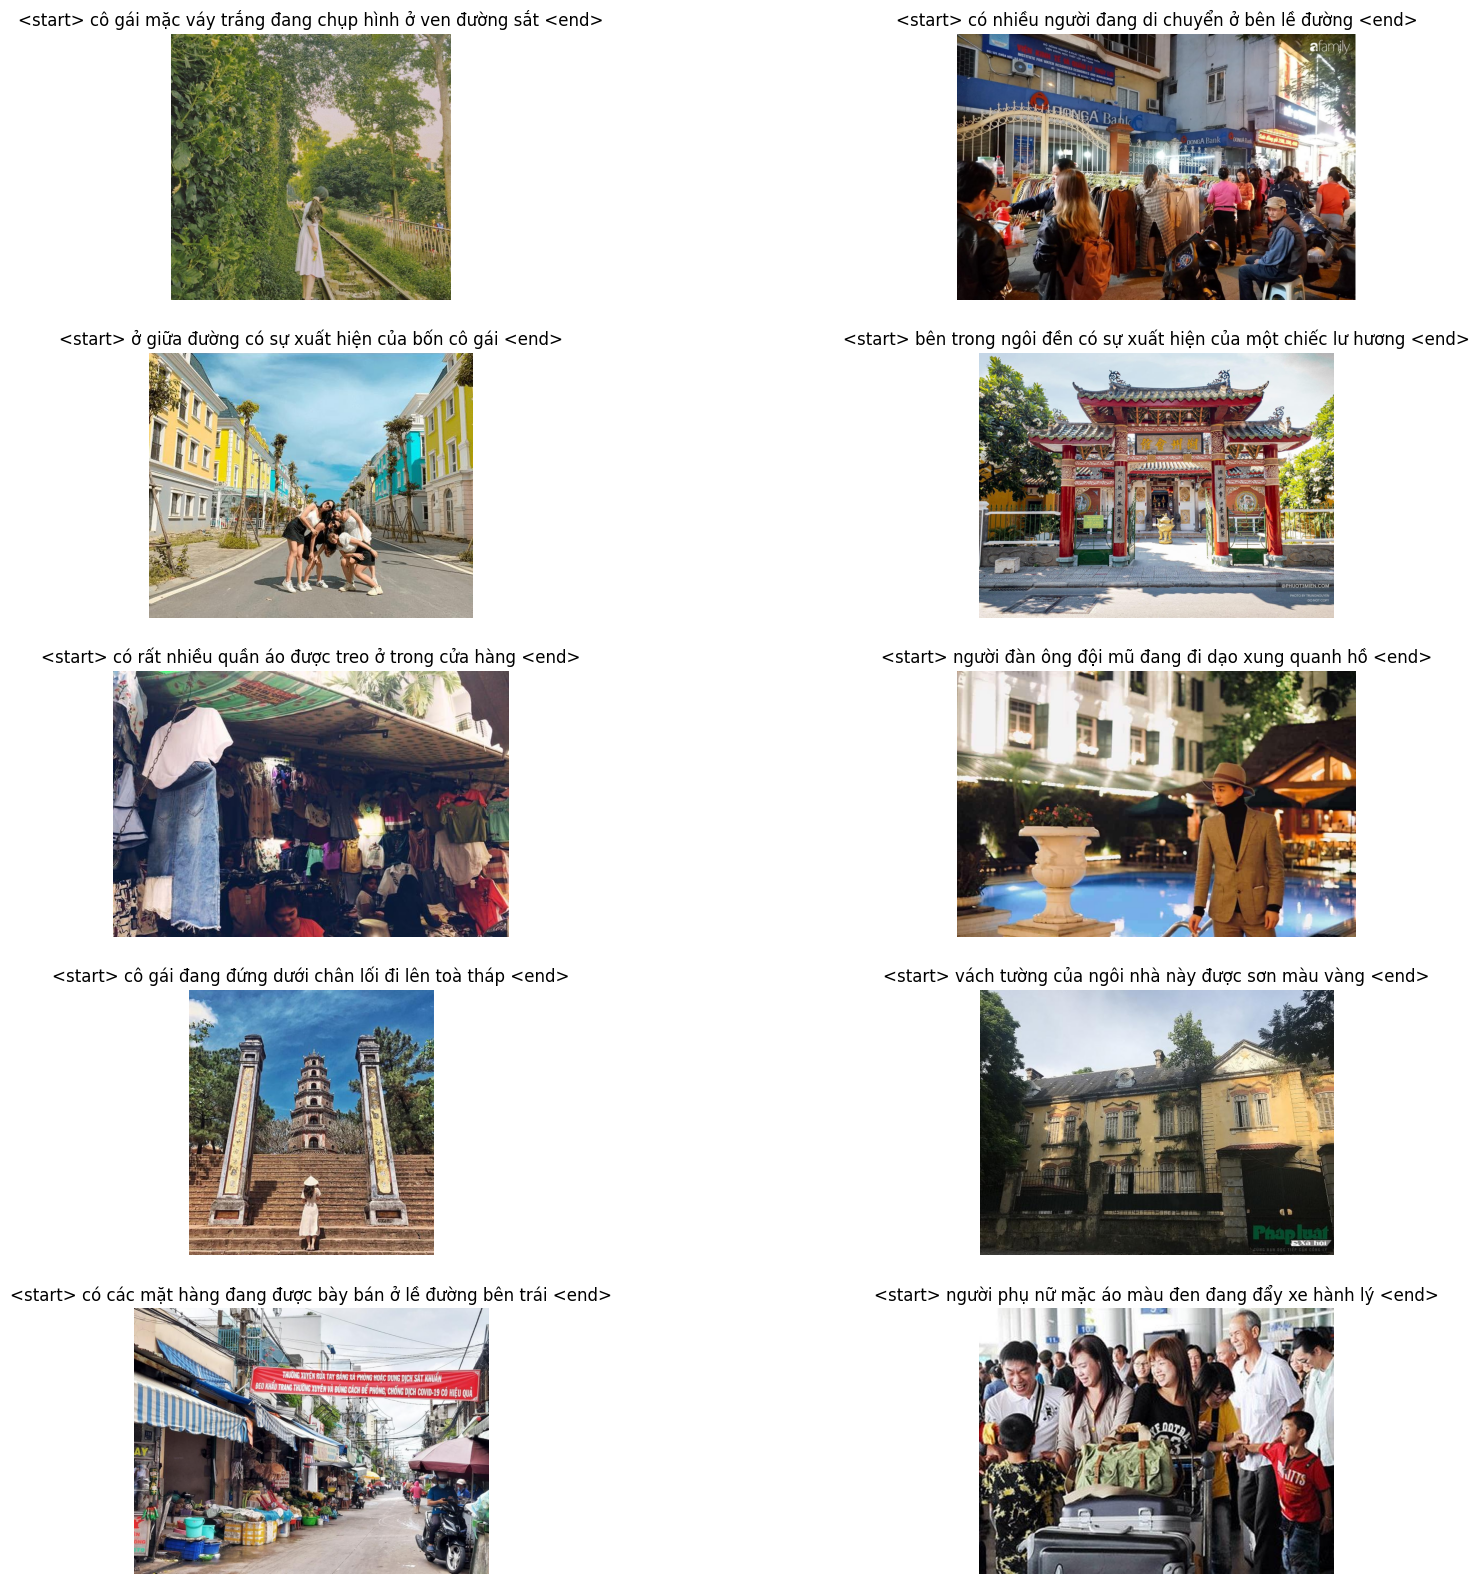

In [24]:
figure = plt.figure(figsize=(20, 20))
for i in range(10):
  plt.subplot(5, 2, i+1)
  idx = np.random.randint(0, 1000)
  images = cv2.imread(cap['image'].iloc[idx])
  plt.imshow(cv2.cvtColor(images, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(df_train_set['caption'].iloc[idx])
plt.show()

# Preprocessing
1. Lower case and remove word not isalpha split 
2. Padding 

In [25]:
def remove_1_length_word(x):
  list = []
  for i in x:
    if len(i)> 1:
      list.append(i)
  return list

In [26]:
# The function removes punctuation marks and digits from the input string and returns the processed string
def standardize(inputs):
  inputs = inputs.lower()
  inputs = re.sub(r'\.!?( *)', ' ', inputs)
  inputs = re.sub(r'[0 - 9]', ' ', inputs)

  return inputs

In [27]:
max_sequence_len = 35

In [28]:
def preprocess(df):
  df = df.copy()
  df['caption_clean'] = df['caption'].apply(standardize)
  df['caption_clean'] = df['caption_clean'].apply(lambda x:  [i.lower() for i in x.split(' ')] )
  df['caption_clean'] = df['caption_clean'].apply(remove_1_length_word)
  df['lens'] = df.caption_clean.apply(lambda x: len(x))
  pad = '<pad>'
  df['caption_clean'] = df.caption_clean.apply(lambda x: x + (max_sequence_len - len(x)) * [pad]) # Thêm các pad giúp đảm bảo tất cả các chuỗi đầu vào có cùng chiều dài. 
  df = df.drop(labels = 'lens', axis = 1)
  return df

In [29]:
df_all = preprocess(pd.concat([df_train_set, df_val_set, df_test_set]))
df = preprocess(cap)
df_train = preprocess(df_train_set)
df_val = preprocess(df_val_set)
df_test = preprocess(df_test_set)

In [30]:
df_all

,image,caption,caption_clean
5,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> người phụ nữ đang cõng một đứa trẻ trên lưng <end>,"[<start>, người, phụ, nữ, đang, cõng, một, đứa, trẻ, trên, lưng, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
6,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> ở trên lưng người phụ nữ có một đứa trẻ <end>,"[<start>, trên, lưng, người, phụ, nữ, có, một, đứa, trẻ, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
7,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> người phụ nữ cõng một đứa bé ở trên lưng <end>,"[<start>, người, phụ, nữ, cõng, một, đứa, bé, trên, lưng, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
8,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> có một đứa bé trên lưng của người phụ nữ <end>,"[<start>, có, một, đứa, bé, trên, lưng, của, người, phụ, nữ, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
9,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> có một đứa trẻ ở trên lưng của một người phụ nữ <end>,"[<start>, có, một, đứa, trẻ, trên, lưng, của, một, người, phụ, nữ, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
...,...,...,...
2785,/kaggle/input/ktvic-dataset/ktvic/images/test/00000011688.jpg,<start> có một cái kệ màu đỏ ở trên mô hình sân bóng đá <end>,"[<start>, có, một, cái, kệ, màu, đỏ, trên, mô, hình, sân, bóng, đá, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
2786,/kaggle/input/ktvic-dataset/ktvic/images/test/00000011688.jpg,<start> có một cái kệ có màu chủ đạo là màu đỏ <end>,"[<start>, có, một, cái, kệ, có, màu, chủ, đạo, là, màu, đỏ, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
2787,/kaggle/input/ktvic-dataset/ktvic/images/test/00000011688.jpg,<start> ở phía dưới cái kệ là mô hình sân bóng đá <end>,"[<start>, phía, dưới, cái, kệ, là, mô, hình, sân, bóng, đá, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
2788,/kaggle/input/ktvic-dataset/ktvic/images/test/00000011688.jpg,<start> có một cái mô hình sân bóng đá ở dưới cái kệ màu đỏ <end>,"[<start>, có, một, cái, mô, hình, sân, bóng, đá, dưới, cái, kệ, màu, đỏ, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


In [31]:
df

,image,caption,caption_clean
5,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> người phụ nữ đang cõng một đứa trẻ trên lưng <end>,"[<start>, người, phụ, nữ, đang, cõng, một, đứa, trẻ, trên, lưng, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
6,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> ở trên lưng người phụ nữ có một đứa trẻ <end>,"[<start>, trên, lưng, người, phụ, nữ, có, một, đứa, trẻ, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
7,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> người phụ nữ cõng một đứa bé ở trên lưng <end>,"[<start>, người, phụ, nữ, cõng, một, đứa, bé, trên, lưng, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
8,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> có một đứa bé trên lưng của người phụ nữ <end>,"[<start>, có, một, đứa, bé, trên, lưng, của, người, phụ, nữ, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
9,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg,<start> có một đứa trẻ ở trên lưng của một người phụ nữ <end>,"[<start>, có, một, đứa, trẻ, trên, lưng, của, một, người, phụ, nữ, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
...,...,...,...
18830,/kaggle/input/ktvic-dataset/ktvic/images/train/00000011695.jpg,<start> có nhiều người đang di chuyển ở bên trong khu phố <end>,"[<start>, có, nhiều, người, đang, di, chuyển, bên, trong, khu, phố, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
18831,/kaggle/input/ktvic-dataset/ktvic/images/train/00000011695.jpg,<start> có nhiều người đang xuất hiện ở trong một khu chợ vào buổi tối <end>,"[<start>, có, nhiều, người, đang, xuất, hiện, trong, một, khu, chợ, vào, buổi, tối, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
18832,/kaggle/input/ktvic-dataset/ktvic/images/train/00000011695.jpg,<start> đây là khung cảnh nhìn từ trên cao của một khu chợ vào buổi tối <end>,"[<start>, đây, là, khung, cảnh, nhìn, từ, trên, cao, của, một, khu, chợ, vào, buổi, tối, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
18833,/kaggle/input/ktvic-dataset/ktvic/images/train/00000011695.jpg,<start> có sự xuất hiện của nhiều sạp hàng ở hai bên đường <end>,"[<start>, có, sự, xuất, hiện, của, nhiều, sạp, hàng, hai, bên, đường, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


In [32]:
df_test

,image,caption,caption_clean
0,/kaggle/input/ktvic-dataset/ktvic/images/test/00000000001.jpg,<start> đây là khung cảnh xuất hiện ở phía trước một căn nhà <end>,"[<start>, đây, là, khung, cảnh, xuất, hiện, phía, trước, một, căn, nhà, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,/kaggle/input/ktvic-dataset/ktvic/images/test/00000000001.jpg,<start> có một căn nhà cao tầng xuất hiện ở trong bức ảnh <end>,"[<start>, có, một, căn, nhà, cao, tầng, xuất, hiện, trong, bức, ảnh, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
2,/kaggle/input/ktvic-dataset/ktvic/images/test/00000000001.jpg,<start> ở trong bức ảnh có sự xuất hiện của một căn nhà cao tầng <end>,"[<start>, trong, bức, ảnh, có, sự, xuất, hiện, của, một, căn, nhà, cao, tầng, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
3,/kaggle/input/ktvic-dataset/ktvic/images/test/00000000001.jpg,<start> có một chiếc xe máy xuất hiện ở trong căn nhà <end>,"[<start>, có, một, chiếc, xe, máy, xuất, hiện, trong, căn, nhà, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
4,/kaggle/input/ktvic-dataset/ktvic/images/test/00000000001.jpg,<start> đây là bức ảnh chụp ở phía trước của một căn nhà cao tầng <end>,"[<start>, đây, là, bức, ảnh, chụp, phía, trước, của, một, căn, nhà, cao, tầng, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
...,...,...,...
2785,/kaggle/input/ktvic-dataset/ktvic/images/test/00000011688.jpg,<start> có một cái kệ màu đỏ ở trên mô hình sân bóng đá <end>,"[<start>, có, một, cái, kệ, màu, đỏ, trên, mô, hình, sân, bóng, đá, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
2786,/kaggle/input/ktvic-dataset/ktvic/images/test/00000011688.jpg,<start> có một cái kệ có màu chủ đạo là màu đỏ <end>,"[<start>, có, một, cái, kệ, có, màu, chủ, đạo, là, màu, đỏ, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
2787,/kaggle/input/ktvic-dataset/ktvic/images/test/00000011688.jpg,<start> ở phía dưới cái kệ là mô hình sân bóng đá <end>,"[<start>, phía, dưới, cái, kệ, là, mô, hình, sân, bóng, đá, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
2788,/kaggle/input/ktvic-dataset/ktvic/images/test/00000011688.jpg,<start> có một cái mô hình sân bóng đá ở dưới cái kệ màu đỏ <end>,"[<start>, có, một, cái, mô, hình, sân, bóng, đá, dưới, cái, kệ, màu, đỏ, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


In [33]:
print(len(df_all))
print(len(df))
print(len(df_train))
print(len(df_val))
print(len(df_test))

21635
18845
15075
3770
2790


## Create dictionary


In [34]:
world_dict = df_all['caption_clean'].apply(lambda x: ' '.join(x)).str.cat(sep = ' ').split(' ')
len(world_dict)

757225

In [35]:
world_dict = Counter(world_dict)
world_dict = sorted(world_dict, key = world_dict.get, reverse = True)
print(world_dict)
word_to_idx = {word:idx for (idx,word) in enumerate(world_dict)}
idx_to_word = {idx:word for (idx,word) in enumerate(world_dict)}
df['token'] = df['caption_clean'].apply(lambda x: [word_to_idx.get(i) for i in x])

df_train['token'] = df_train['caption_clean'].apply(lambda x: [word_to_idx.get(i) for i in x])
df_val['token'] = df_val['caption_clean'].apply(lambda x: [word_to_idx.get(i) for i in x])
df_test['token'] = df_test['caption_clean'].apply(lambda x: [word_to_idx.get(i) for i in x])

#vocab size
print(len(word_to_idx))
vocab_size = len(word_to_idx)

['<pad>', '<start>', '<end>', 'có', 'một', 'đang', 'người', 'hiện', 'xuất', 'trên', 'hàng', 'của', 'bên', 'trong', 'nhiều', 'những', 'chiếc', 'trước', 'nữ', 'áo', 'phụ', 'mặc', 'màu', 'được', 'gái', 'cô', 'đứng', 'xe', 'đường', 'phía', 'hai', 'sự', 'khu', 'nhà', 'ông', 'đàn', 'bức', 'là', 'cửa', 'ảnh', 'quầy', 'cái', 'con', 'cây', 'mặt', 'bày', 'vài', 'tay', 'di', 'bán', 'hình', 'đây', 'ngồi', 'xanh', 'máy', 'khung', 'và', 'chuyển', 'trắng', 'đồ', 'ngôi', 'chợ', 'cảnh', 'đi', 'chụp', 'thị', 'siêu', 'các', 'nhóm', 'đỏ', 'ăn', 'kệ', 'này', 'cầm', 'đen', 'phố', 'quả', 'lá', 'vào', 'nhau', 'trang', 'hoa', 'căn', 'tấm', 'trưng', 'vực', 'toà', 'rau', 'vàng', 'tường', 'biển', 'bàn', 'nước', 'đội', 'trái', 'sản', 'bộ', 'đeo', 'trí', 'cạnh', 'phẩm', 'sau', 'thuyền', 'loại', 'quán', 'thanh', 'quần', 'thông', 'đẩy', 'tranh', 'với', 'củ', 'cùng', 'nhìn', 'quanh', 'sông', 'ba', 'hè', 'cổng', 'đặt', 'phòng', 'ghế', 'đèn', 'vỉa', 'cổ', 'gần', 'nón', 'giữa', 'mua', 'treo', 'đôi', 'gian', 'bé', 'trai',

In [36]:
with open('/kaggle/working/vocabulary_data.pkl', 'wb') as f: 
    pickle.dump({'word_to_idx': word_to_idx, 'idx_to_word': idx_to_word, 'world_dict': world_dict}, f)

In [37]:
train = df_train
val = df_val
test = df_test
print(len(train), train['image'].nunique())
print(len(val), val['image'].nunique())
print(len(test), test['image'].nunique())

15075 3015
3770 754
2790 558


# Image ==> EfficientNetV2 ==> {imagename : image_emb}

In [38]:
class extractFeatureEfficientNetV2():
  def __init__(self,data):
    self.data = data
    self.scaler = transforms.Resize([224, 224])
    self.normalizer = transforms.Normalize(
        mean  = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])
    self.transform = transforms.ToTensor()
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    # print('check 1 ')
    img_name = self.data.iloc[idx]['image']
    # print('check 2 ')
    img = Image.open(img_name).convert('RGB')
    img =  self.normalizer(self.transform((self.scaler(img))))
    if img.shape[0] == 1:
      print(img.shape)
    return img_name, img

# Extract Feature

In [39]:
# Embedding ảnh
train_unique_image = train[['image']].drop_duplicates()
train_extract = extractFeatureEfficientNetV2(train_unique_image)
train_loader = DataLoader(train_extract, batch_size=1, shuffle=True)

val_unique_image = val[['image']].drop_duplicates()
val_extract = extractFeatureEfficientNetV2(val_unique_image)
val_loader = DataLoader(val_extract, batch_size=1, shuffle=False)

test_unique_image = test[['image']].drop_duplicates()
test_extract = extractFeatureEfficientNetV2(test_unique_image)
test_loader = DataLoader(test_extract, batch_size=1, shuffle=False)

In [40]:
for (image_name, img) in train_loader:
    print(image_name)
    print(img.shape)
    break

('/kaggle/input/ktvic-dataset/ktvic/images/train/00000004569.jpg',)
torch.Size([1, 3, 224, 224])


In [41]:
train_unique_image.head()

,image
5,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000003.jpg
10,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000004.jpg
15,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000005.jpg
20,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000006.jpg
25,/kaggle/input/ktvic-dataset/ktvic/images/train/00000000009.jpg


# EfficientNetV2 model


In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_img = torchvision.models.efficientnet_v2_s(weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 95.4MB/s]


In [43]:
model_img.eval()
model_img_layer_4 = model_img._modules.get('features')#[0:-1]
print(model_img_layer_4)
class fine_tune_model(nn.Module):
    def __init__(self, model_img_layer_4):
        super(fine_tune_model, self).__init__()
        self.model_img_layer_4 = model_img_layer_4
        self.conv = nn.LazyConv2d(512, 1, padding='same')
    def forward(self, x):
        x = self.model_img_layer_4(x)
        x = self.conv(x)
        return x
EfficientNet_V2_layer_4 = fine_tune_model(model_img_layer_4).to(device)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_de

In [44]:
from torchsummary import summary
summary(model_img_layer_4, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

In [45]:
def get_vector(t_img):
  my_emb = torch.zeros(1, embedding_size, 7, 7)
  t_img = torch.autograd.Variable(t_img).to(device)
  def hook(model, input, output):

    my_emb.copy_(output.data)
  h = model_img_layer_4.register_forward_hook(hook)
  model_img_layer_4(t_img)
  h.remove()
  return my_emb

In [46]:
img_emb_train = {image_name[0]: get_vector(image) for image_name, image in tqdm(train_loader)}

  0%|          | 0/3015 [00:00<?, ?it/s]

In [47]:
img_emb_val = {image_name[0]: get_vector(image) for image_name, image in tqdm(val_loader)}

  0%|          | 0/754 [00:00<?, ?it/s]

In [48]:
img_emb_test = {image_name[0]:get_vector(image) for image_name, image in tqdm(test_loader)}

  0%|          | 0/558 [00:00<?, ?it/s]

In [49]:
with open('/kaggle/working/train_img_emb.pkl', 'wb') as f:
  pickle.dump(img_emb_train, f)
with open('/kaggle/working/val_img_emb.pkl', 'wb') as f: 
  pickle.dump(img_emb_val, f)
with open('/kaggle/working/test_img_emb.pkl', 'wb') as f:
  pickle.dump(img_emb_test, f)

# Create dataset for Transformer model

In [50]:
class image_emb_seq_dataset():
  def __init__(self,data, file_path ):
    self.data = data
    self.emb_dict = pd.read_pickle(file_path)
  def __len__(self):
    return len(self.data)
  def __getitem__(self,idx):
    seq = self.data.iloc[idx]['token']
    target = seq[1:] + [0]
    image_name = self.data.iloc[idx]['image']
    img_emb = self.emb_dict[image_name]
    img_emb = torch.permute(img_emb, (0, 2, 3, 1))
    img_emb = img_emb.view(img_emb.size(0), -1, img_emb.size(3))
    return torch.tensor(seq), torch.tensor(target), img_emb

In [51]:
train_emb_path = '/kaggle/working/train_img_emb.pkl'
train_image_seq = DataLoader(image_emb_seq_dataset(train, train_emb_path), batch_size = batch_size, shuffle = True)

val_emb_path = '/kaggle/working/val_img_emb.pkl'
val_image_seq = DataLoader(image_emb_seq_dataset(val, val_emb_path), batch_size = batch_size, shuffle = False)

test_emb_path = '/kaggle/working/test_img_emb.pkl'
test_image_seq = DataLoader(image_emb_seq_dataset(test, test_emb_path), batch_size = batch_size, shuffle = False)

In [52]:
for (seq, target, image) in train_image_seq:
    print(seq.shape)
    print(target.shape)
    print(image.shape)
    break

torch.Size([64, 35])
torch.Size([64, 35])
torch.Size([64, 1, 49, 1280])


In [53]:
for (seq, target, image) in val_image_seq:
    print(seq.shape)
    print(target.shape)
    print(image.shape)
    break

torch.Size([64, 35])
torch.Size([64, 35])
torch.Size([64, 1, 49, 1280])


In [54]:
for (seq, target, image) in test_image_seq:
    print(seq.shape)
    print(target.shape)
    print(image.shape)
    break

torch.Size([64, 35])
torch.Size([64, 35])
torch.Size([64, 1, 49, 1280])


# Create Transformer model

## Position Encoding

In [55]:
class position_encoding(nn.Module):
  def __init__(self,d_model = 512, max_len = max_sequence_len, dropout = 0.1):
    super().__init__()

    self.dropout = nn.Dropout(dropout)
    
    pe = torch.zeros(max_len, d_model) # (33,512)
    pos = torch.arange(0,max_len).unsqueeze(1) # (33,1)
    div_term = torch.exp(torch.arange(0,d_model, 2 ).float() * (-math.log(10000.0) / d_model)) # 256
    pe[:,::2] = torch.sin(pos * div_term)
    pe[:,1::2] = torch.cos(pos * div_term)
    pe = pe.unsqueeze(0) # (1,32,512)
    self.register_buffer('pe', pe)

  def forward(self,x):
    if x.size(0) > self.pe.size(0):
      self.pe = self.pe.repeat(x.size(0), 1, 1)
    self.pe = self.pe[:x.size(0), :, :]
    return self.dropout(self.pe +x) 

## Transformer Decoder

In [56]:
class Imagecaptionmodel(nn.Module):
  def __init__(self, vocab_size=vocab_size, embedding_size=embedding_size, max_len=max_sequence_len, n_head=16, num_decoder_layer=4):
    super().__init__()
    self.position_encoding = position_encoding(d_model = embedding_size)

    self.transformer_decoder_layer  = nn.TransformerDecoderLayer(d_model = embedding_size, nhead = n_head)
    self.transformer_decoder = nn.TransformerDecoder(self.transformer_decoder_layer, num_layers = num_decoder_layer)
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.FC = nn.LazyLinear(vocab_size)
    self.initweights()
    self.embedding_size = embedding_size
      
  def initweights(self):
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.FC.weight.data.uniform_(-0.1, 0.1)
    self.FC.bias.data.zero_()
  def create_mask(self, seq):
      'create mask for mask attention'
      attention_mask  = torch.ones(seq.size(1), seq.size(1))
      attention_mask  = torch.tril(attention_mask)
      attention_mask = attention_mask.masked_fill(attention_mask == 0, float('-inf')).masked_fill(attention_mask == 1, 0)

      pad_mask = seq.masked_fill(seq == 0, float(0.0)).masked_fill(seq > 0, float(1.0))
      pad_mask_bool = seq == 0 
      return attention_mask, pad_mask, pad_mask_bool
      
  def forward(self,seq, image_embedding):
    image_embedding  = image_embedding.permute(1,0,2) # 49,32,512
    x = self.embedding(seq) * math.sqrt(self.embedding_size)
    x = self.position_encoding(x) # 32, 33 512
    x = x.permute(1, 0, 2) # (seqlen, batchsize, embedding)

    attention_mask, pad_mask, pad_mask_bool = self.create_mask(seq)
    attention_mask, pad_mask, pad_mask_bool = attention_mask.to(device), pad_mask.to(device), pad_mask_bool.to(device)
    
    x = self.transformer_decoder(memory = image_embedding, tgt = x, tgt_mask = attention_mask, tgt_key_padding_mask = pad_mask_bool)  #(T, N, E) (33, 32, 512)
    out = self.FC(x)
    return out, pad_mask

## Print shape model

In [57]:
from torchsummary import summary
for (seq, target,image) in train_image_seq:
    print(seq.shape)
    image = image.squeeze(1).to(device)
    seq = seq.to(device)
    print('image', image.shape)
    print(torch.max(seq))
    print(target.shape)
    print(image.shape)
    model = Imagecaptionmodel().to(device)
    print('output shape  :', model(seq, image)[0].shape)
    break

torch.Size([64, 35])
image torch.Size([64, 49, 1280])
tensor(1633, device='cuda:0')
torch.Size([64, 35])
torch.Size([64, 49, 1280])
output shape  : torch.Size([35, 64, 1823])


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


# Training loop

In [58]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np

In [59]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, scheduler, device, patience=3):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.device = device
        self.patience = patience
        self.best_loss = float('inf')
        self.early_stopping_counter = 0

        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0
        total_words = 0
    
        with tqdm(total=len(self.train_loader), unit="batch") as pbar:
            for seq, target, image in self.train_loader:
                assert seq.dim() == 2, "Sequence input must be 2D (batch_size, seq_len)"
                assert target.dim() == 2, "Target input must be 2D (batch_size, seq_len)"
                assert image.dim() in [3, 4], "Image input must be 3D or 4D"
    
                seq, target, image = seq.to(self.device), target.to(self.device), image.squeeze(1).to(self.device)
                
                self.optimizer.zero_grad()
                out, pad_mask = self.model(seq, image)
                out = out.permute(1, 2, 0)  # (batch, vocab_size, seq_len)
    
                loss = self.criterion(out, target)
                loss_pad_mask = torch.mul(loss, pad_mask)
                loss_final = loss_pad_mask.sum() / pad_mask.sum()
                
                loss_final.backward()
                self.optimizer.step()
    
                total_loss += loss_pad_mask.sum().detach().item()
                total_words += pad_mask.sum().detach().item()
    
                pbar.set_description(f"Training Loss: {total_loss / total_words:.4f}")
                pbar.update(1)
        
        return total_loss / total_words


    def validate_one_epoch(self):
        self.model.eval()
        total_loss = 0
        total_words = 0

        with torch.no_grad():
            for seq, target, image in self.val_loader:
                seq, target, image = seq.to(self.device), target.to(self.device), image.squeeze(1).to(self.device)

                out, pad_mask = self.model(seq, image)
                out = out.permute(1, 2, 0)

                loss = self.criterion(out, target)
                loss_pad_mask = torch.mul(loss, pad_mask)
                total_loss += loss_pad_mask.sum().item()
                total_words += pad_mask.sum().item()

        return total_loss / total_words

    def train(self, epochs, save_path):
        for epoch in range(1, epochs + 1):
            print(f"\nEpoch {epoch}/{epochs}")
            train_loss = self.train_one_epoch()
            val_loss = self.validate_one_epoch()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.learning_rates.append(self.optimizer.param_groups[0]["lr"])
    
            print(f"\nTraining Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | Learning Rate: {self.optimizer.param_groups[0]['lr']:.12f}")
            print("-" * 50)
    
            self.scheduler.step(val_loss)
            
            if val_loss < self.best_loss:
                print(f"Validation loss improved from {self.best_loss:.4f} to {val_loss:.4f}. Saving model.")
                self.best_loss = val_loss
                torch.save(self.model, save_path)
                self.early_stopping_counter = 0
            else:
                self.early_stopping_counter += 1
                print(f"Early stopping counter: {self.early_stopping_counter}/{self.patience}")
    
            if self.early_stopping_counter >= self.patience:
                print("Early stopping triggered.")
                break
                
    def evaluate(self, test_loader):
        self.model.eval()
        total_loss = 0
        total_words = 0
    
        with torch.no_grad():
            for seq, target, image in test_loader:
                seq, target, image = seq.to(self.device), target.to(self.device), image.squeeze(1).to(self.device)
    
                out, pad_mask = self.model(seq, image)
                out = out.permute(1, 2, 0)
    
                loss = self.criterion(out, target)
                loss_pad_mask = torch.mul(loss, pad_mask)
                total_loss += loss_pad_mask.sum().item()
                total_words += pad_mask.sum().item()
    
        avg_loss = total_loss / total_words
        print(f"Test Loss: {avg_loss:.4f}")
        return avg_loss

    def plot_metrics(self):
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 6))


        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Train Loss", marker='o')
        plt.plot(self.val_losses, label="Validation Loss", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss per Epoch")

        plt.subplot(1, 2, 2)
        plt.plot(self.learning_rates, label="Learning Rate", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.legend()
        plt.title("Learning Rate per Epoch")

        plt.tight_layout()
        plt.show()

In [60]:
ict_model = Imagecaptionmodel(n_head=20, num_decoder_layer=6)
optimizer = torch.optim.Adam(ict_model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss(reduction='none')
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1, verbose=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainer = Trainer(
    model=ict_model,
    train_loader=train_image_seq,
    val_loader=val_image_seq,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    device=device,
    patience=3
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [61]:
import time
start_time = time.time()

trainer.train(epochs=300, save_path="./BestModel.pth")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Thời gian huấn luyện: {elapsed_time:.2f} giây")


Epoch 1/300


Training Loss: 6.4008: 100%|██████████| 236/236 [01:09<00:00,  3.41batch/s]



Training Loss: 6.4008 | Validation Loss: 5.4510 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from inf to 5.4510. Saving model.

Epoch 2/300


Training Loss: 5.1344: 100%|██████████| 236/236 [01:09<00:00,  3.41batch/s]



Training Loss: 5.1344 | Validation Loss: 4.7706 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 5.4510 to 4.7706. Saving model.

Epoch 3/300


Training Loss: 4.6056: 100%|██████████| 236/236 [01:09<00:00,  3.41batch/s]



Training Loss: 4.6056 | Validation Loss: 4.3398 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 4.7706 to 4.3398. Saving model.

Epoch 4/300


Training Loss: 4.2299: 100%|██████████| 236/236 [01:09<00:00,  3.41batch/s]



Training Loss: 4.2299 | Validation Loss: 4.0085 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 4.3398 to 4.0085. Saving model.

Epoch 5/300


Training Loss: 3.9338: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 3.9338 | Validation Loss: 3.7484 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 4.0085 to 3.7484. Saving model.

Epoch 6/300


Training Loss: 3.6973: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 3.6973 | Validation Loss: 3.5437 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 3.7484 to 3.5437. Saving model.

Epoch 7/300


Training Loss: 3.5069: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 3.5069 | Validation Loss: 3.3821 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 3.5437 to 3.3821. Saving model.

Epoch 8/300


Training Loss: 3.3498: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 3.3498 | Validation Loss: 3.2504 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 3.3821 to 3.2504. Saving model.

Epoch 9/300


Training Loss: 3.2197: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 3.2197 | Validation Loss: 3.1417 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 3.2504 to 3.1417. Saving model.

Epoch 10/300


Training Loss: 3.1093: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 3.1093 | Validation Loss: 3.0484 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 3.1417 to 3.0484. Saving model.

Epoch 11/300


Training Loss: 3.0150: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 3.0150 | Validation Loss: 2.9660 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 3.0484 to 2.9660. Saving model.

Epoch 12/300


Training Loss: 2.9304: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.9304 | Validation Loss: 2.8942 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.9660 to 2.8942. Saving model.

Epoch 13/300


Training Loss: 2.8566: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.8566 | Validation Loss: 2.8303 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.8942 to 2.8303. Saving model.

Epoch 14/300


Training Loss: 2.7905: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.7905 | Validation Loss: 2.7749 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.8303 to 2.7749. Saving model.

Epoch 15/300


Training Loss: 2.7300: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.7300 | Validation Loss: 2.7224 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.7749 to 2.7224. Saving model.

Epoch 16/300


Training Loss: 2.6743: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.6743 | Validation Loss: 2.6756 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.7224 to 2.6756. Saving model.

Epoch 17/300


Training Loss: 2.6219: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.6219 | Validation Loss: 2.6324 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.6756 to 2.6324. Saving model.

Epoch 18/300


Training Loss: 2.5767: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.5767 | Validation Loss: 2.5934 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.6324 to 2.5934. Saving model.

Epoch 19/300


Training Loss: 2.5348: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.5348 | Validation Loss: 2.5573 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.5934 to 2.5573. Saving model.

Epoch 20/300


Training Loss: 2.4952: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.4952 | Validation Loss: 2.5252 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.5573 to 2.5252. Saving model.

Epoch 21/300


Training Loss: 2.4573: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.4573 | Validation Loss: 2.4952 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.5252 to 2.4952. Saving model.

Epoch 22/300


Training Loss: 2.4223: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.4223 | Validation Loss: 2.4667 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.4952 to 2.4667. Saving model.

Epoch 23/300


Training Loss: 2.3896: 100%|██████████| 236/236 [01:09<00:00,  3.41batch/s]



Training Loss: 2.3896 | Validation Loss: 2.4422 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.4667 to 2.4422. Saving model.

Epoch 24/300


Training Loss: 2.3587: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.3587 | Validation Loss: 2.4170 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.4422 to 2.4170. Saving model.

Epoch 25/300


Training Loss: 2.3296: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.3296 | Validation Loss: 2.3933 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.4170 to 2.3933. Saving model.

Epoch 26/300


Training Loss: 2.3028: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.3028 | Validation Loss: 2.3747 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.3933 to 2.3747. Saving model.

Epoch 27/300


Training Loss: 2.2761: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.2761 | Validation Loss: 2.3544 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.3747 to 2.3544. Saving model.

Epoch 28/300


Training Loss: 2.2518: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.2518 | Validation Loss: 2.3350 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.3544 to 2.3350. Saving model.

Epoch 29/300


Training Loss: 2.2277: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.2277 | Validation Loss: 2.3180 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.3350 to 2.3180. Saving model.

Epoch 30/300


Training Loss: 2.2053: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.2053 | Validation Loss: 2.3005 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.3180 to 2.3005. Saving model.

Epoch 31/300


Training Loss: 2.1836: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.1836 | Validation Loss: 2.2853 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.3005 to 2.2853. Saving model.

Epoch 32/300


Training Loss: 2.1623: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.1623 | Validation Loss: 2.2709 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.2853 to 2.2709. Saving model.

Epoch 33/300


Training Loss: 2.1428: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.1428 | Validation Loss: 2.2567 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.2709 to 2.2567. Saving model.

Epoch 34/300


Training Loss: 2.1233: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.1233 | Validation Loss: 2.2432 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.2567 to 2.2432. Saving model.

Epoch 35/300


Training Loss: 2.1051: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.1051 | Validation Loss: 2.2317 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.2432 to 2.2317. Saving model.

Epoch 36/300


Training Loss: 2.0872: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.0872 | Validation Loss: 2.2167 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.2317 to 2.2167. Saving model.

Epoch 37/300


Training Loss: 2.0694: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.0694 | Validation Loss: 2.2066 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.2167 to 2.2066. Saving model.

Epoch 38/300


Training Loss: 2.0520: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.0520 | Validation Loss: 2.1953 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.2066 to 2.1953. Saving model.

Epoch 39/300


Training Loss: 2.0368: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.0368 | Validation Loss: 2.1857 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.1953 to 2.1857. Saving model.

Epoch 40/300


Training Loss: 2.0233: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.0233 | Validation Loss: 2.1751 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.1857 to 2.1751. Saving model.

Epoch 41/300


Training Loss: 2.0071: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 2.0071 | Validation Loss: 2.1658 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.1751 to 2.1658. Saving model.

Epoch 42/300


Training Loss: 1.9920: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.9920 | Validation Loss: 2.1560 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.1658 to 2.1560. Saving model.

Epoch 43/300


Training Loss: 1.9777: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.9777 | Validation Loss: 2.1467 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.1560 to 2.1467. Saving model.

Epoch 44/300


Training Loss: 1.9647: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.9647 | Validation Loss: 2.1390 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.1467 to 2.1390. Saving model.

Epoch 45/300


Training Loss: 1.9504: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.9504 | Validation Loss: 2.1301 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.1390 to 2.1301. Saving model.

Epoch 46/300


Training Loss: 1.9387: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.9387 | Validation Loss: 2.1228 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.1301 to 2.1228. Saving model.

Epoch 47/300


Training Loss: 1.9248: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.9248 | Validation Loss: 2.1146 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.1228 to 2.1146. Saving model.

Epoch 48/300


Training Loss: 1.9117: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.9117 | Validation Loss: 2.1078 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.1146 to 2.1078. Saving model.

Epoch 49/300


Training Loss: 1.9005: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.9005 | Validation Loss: 2.1007 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.1078 to 2.1007. Saving model.

Epoch 50/300


Training Loss: 1.8879: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.8879 | Validation Loss: 2.0918 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.1007 to 2.0918. Saving model.

Epoch 51/300


Training Loss: 1.8777: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.8777 | Validation Loss: 2.0851 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0918 to 2.0851. Saving model.

Epoch 52/300


Training Loss: 1.8668: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.8668 | Validation Loss: 2.0787 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0851 to 2.0787. Saving model.

Epoch 53/300


Training Loss: 1.8545: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.8545 | Validation Loss: 2.0735 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0787 to 2.0735. Saving model.

Epoch 54/300


Training Loss: 1.8437: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.8437 | Validation Loss: 2.0677 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0735 to 2.0677. Saving model.

Epoch 55/300


Training Loss: 1.8327: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.8327 | Validation Loss: 2.0622 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0677 to 2.0622. Saving model.

Epoch 56/300


Training Loss: 1.8208: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.8208 | Validation Loss: 2.0568 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0622 to 2.0568. Saving model.

Epoch 57/300


Training Loss: 1.8131: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.8131 | Validation Loss: 2.0519 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0568 to 2.0519. Saving model.

Epoch 58/300


Training Loss: 1.8005: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.8005 | Validation Loss: 2.0462 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0519 to 2.0462. Saving model.

Epoch 59/300


Training Loss: 1.7918: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.7918 | Validation Loss: 2.0393 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0462 to 2.0393. Saving model.

Epoch 60/300


Training Loss: 1.7828: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.7828 | Validation Loss: 2.0365 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0393 to 2.0365. Saving model.

Epoch 61/300


Training Loss: 1.7731: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.7731 | Validation Loss: 2.0306 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0365 to 2.0306. Saving model.

Epoch 62/300


Training Loss: 1.7636: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.7636 | Validation Loss: 2.0260 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0306 to 2.0260. Saving model.

Epoch 63/300


Training Loss: 1.7534: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.7534 | Validation Loss: 2.0223 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0260 to 2.0223. Saving model.

Epoch 64/300


Training Loss: 1.7440: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.7440 | Validation Loss: 2.0178 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0223 to 2.0178. Saving model.

Epoch 65/300


Training Loss: 1.7377: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.7377 | Validation Loss: 2.0139 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0178 to 2.0139. Saving model.

Epoch 66/300


Training Loss: 1.7263: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.7263 | Validation Loss: 2.0094 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0139 to 2.0094. Saving model.

Epoch 67/300


Training Loss: 1.7186: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.7186 | Validation Loss: 2.0060 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0094 to 2.0060. Saving model.

Epoch 68/300


Training Loss: 1.7091: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.7091 | Validation Loss: 2.0023 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0060 to 2.0023. Saving model.

Epoch 69/300


Training Loss: 1.7013: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.7013 | Validation Loss: 1.9984 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 2.0023 to 1.9984. Saving model.

Epoch 70/300


Training Loss: 1.6937: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.6937 | Validation Loss: 1.9960 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9984 to 1.9960. Saving model.

Epoch 71/300


Training Loss: 1.6851: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.6851 | Validation Loss: 1.9916 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9960 to 1.9916. Saving model.

Epoch 72/300


Training Loss: 1.6754: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.6754 | Validation Loss: 1.9869 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9916 to 1.9869. Saving model.

Epoch 73/300


Training Loss: 1.6686: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.6686 | Validation Loss: 1.9850 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9869 to 1.9850. Saving model.

Epoch 74/300


Training Loss: 1.6611: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.6611 | Validation Loss: 1.9817 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9850 to 1.9817. Saving model.

Epoch 75/300


Training Loss: 1.6525: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.6525 | Validation Loss: 1.9807 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9817 to 1.9807. Saving model.

Epoch 76/300


Training Loss: 1.6449: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.6449 | Validation Loss: 1.9759 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9807 to 1.9759. Saving model.

Epoch 77/300


Training Loss: 1.6377: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.6377 | Validation Loss: 1.9754 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9759 to 1.9754. Saving model.

Epoch 78/300


Training Loss: 1.6309: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.6309 | Validation Loss: 1.9716 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9754 to 1.9716. Saving model.

Epoch 79/300


Training Loss: 1.6235: 100%|██████████| 236/236 [01:09<00:00,  3.40batch/s]



Training Loss: 1.6235 | Validation Loss: 1.9679 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9716 to 1.9679. Saving model.

Epoch 80/300


Training Loss: 1.6146: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.6146 | Validation Loss: 1.9638 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9679 to 1.9638. Saving model.

Epoch 81/300


Training Loss: 1.6081: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.6081 | Validation Loss: 1.9633 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9638 to 1.9633. Saving model.

Epoch 82/300


Training Loss: 1.6005: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.6005 | Validation Loss: 1.9604 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9633 to 1.9604. Saving model.

Epoch 83/300


Training Loss: 1.5942: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5942 | Validation Loss: 1.9585 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9604 to 1.9585. Saving model.

Epoch 84/300


Training Loss: 1.5866: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5866 | Validation Loss: 1.9562 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9585 to 1.9562. Saving model.

Epoch 85/300


Training Loss: 1.5807: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5807 | Validation Loss: 1.9550 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9562 to 1.9550. Saving model.

Epoch 86/300


Training Loss: 1.5738: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5738 | Validation Loss: 1.9506 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9550 to 1.9506. Saving model.

Epoch 87/300


Training Loss: 1.5671: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5671 | Validation Loss: 1.9486 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9506 to 1.9486. Saving model.

Epoch 88/300


Training Loss: 1.5607: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5607 | Validation Loss: 1.9463 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9486 to 1.9463. Saving model.

Epoch 89/300


Training Loss: 1.5528: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5528 | Validation Loss: 1.9452 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9463 to 1.9452. Saving model.

Epoch 90/300


Training Loss: 1.5479: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5479 | Validation Loss: 1.9434 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9452 to 1.9434. Saving model.

Epoch 91/300


Training Loss: 1.5400: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5400 | Validation Loss: 1.9396 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9434 to 1.9396. Saving model.

Epoch 92/300


Training Loss: 1.5344: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5344 | Validation Loss: 1.9385 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9396 to 1.9385. Saving model.

Epoch 93/300


Training Loss: 1.5259: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5259 | Validation Loss: 1.9384 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9385 to 1.9384. Saving model.

Epoch 94/300


Training Loss: 1.5218: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5218 | Validation Loss: 1.9368 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9384 to 1.9368. Saving model.

Epoch 95/300


Training Loss: 1.5144: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5144 | Validation Loss: 1.9333 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9368 to 1.9333. Saving model.

Epoch 96/300


Training Loss: 1.5071: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5071 | Validation Loss: 1.9339 | Learning Rate: 0.000001000000
--------------------------------------------------
Early stopping counter: 1/3

Epoch 97/300


Training Loss: 1.5014: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.5014 | Validation Loss: 1.9322 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9333 to 1.9322. Saving model.

Epoch 98/300


Training Loss: 1.4962: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4962 | Validation Loss: 1.9308 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9322 to 1.9308. Saving model.

Epoch 99/300


Training Loss: 1.4906: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4906 | Validation Loss: 1.9286 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9308 to 1.9286. Saving model.

Epoch 100/300


Training Loss: 1.4821: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4821 | Validation Loss: 1.9282 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9286 to 1.9282. Saving model.

Epoch 101/300


Training Loss: 1.4776: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4776 | Validation Loss: 1.9252 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9282 to 1.9252. Saving model.

Epoch 102/300


Training Loss: 1.4728: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4728 | Validation Loss: 1.9235 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9252 to 1.9235. Saving model.

Epoch 103/300


Training Loss: 1.4662: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4662 | Validation Loss: 1.9226 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9235 to 1.9226. Saving model.

Epoch 104/300


Training Loss: 1.4607: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4607 | Validation Loss: 1.9219 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9226 to 1.9219. Saving model.

Epoch 105/300


Training Loss: 1.4540: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4540 | Validation Loss: 1.9205 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9219 to 1.9205. Saving model.

Epoch 106/300


Training Loss: 1.4491: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4491 | Validation Loss: 1.9193 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9205 to 1.9193. Saving model.

Epoch 107/300


Training Loss: 1.4436: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4436 | Validation Loss: 1.9187 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9193 to 1.9187. Saving model.

Epoch 108/300


Training Loss: 1.4373: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4373 | Validation Loss: 1.9188 | Learning Rate: 0.000001000000
--------------------------------------------------
Early stopping counter: 1/3

Epoch 109/300


Training Loss: 1.4317: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4317 | Validation Loss: 1.9166 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9187 to 1.9166. Saving model.

Epoch 110/300


Training Loss: 1.4266: 100%|██████████| 236/236 [01:09<00:00,  3.38batch/s]



Training Loss: 1.4266 | Validation Loss: 1.9145 | Learning Rate: 0.000001000000
--------------------------------------------------
Validation loss improved from 1.9166 to 1.9145. Saving model.

Epoch 111/300


Training Loss: 1.4206: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4206 | Validation Loss: 1.9148 | Learning Rate: 0.000001000000
--------------------------------------------------
Early stopping counter: 1/3

Epoch 112/300


Training Loss: 1.4159: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4159 | Validation Loss: 1.9152 | Learning Rate: 0.000001000000
--------------------------------------------------
Early stopping counter: 2/3

Epoch 113/300


Training Loss: 1.4091: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4091 | Validation Loss: 1.9134 | Learning Rate: 0.000000100000
--------------------------------------------------
Validation loss improved from 1.9145 to 1.9134. Saving model.

Epoch 114/300


Training Loss: 1.4072: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4072 | Validation Loss: 1.9123 | Learning Rate: 0.000000100000
--------------------------------------------------
Validation loss improved from 1.9134 to 1.9123. Saving model.

Epoch 115/300


Training Loss: 1.4062: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4062 | Validation Loss: 1.9125 | Learning Rate: 0.000000100000
--------------------------------------------------
Early stopping counter: 1/3

Epoch 116/300


Training Loss: 1.4073: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4073 | Validation Loss: 1.9124 | Learning Rate: 0.000000100000
--------------------------------------------------
Early stopping counter: 2/3

Epoch 117/300


Training Loss: 1.4059: 100%|██████████| 236/236 [01:09<00:00,  3.39batch/s]



Training Loss: 1.4059 | Validation Loss: 1.9125 | Learning Rate: 0.000000010000
--------------------------------------------------
Early stopping counter: 3/3
Early stopping triggered.
Thời gian huấn luyện: 9063.66 giây


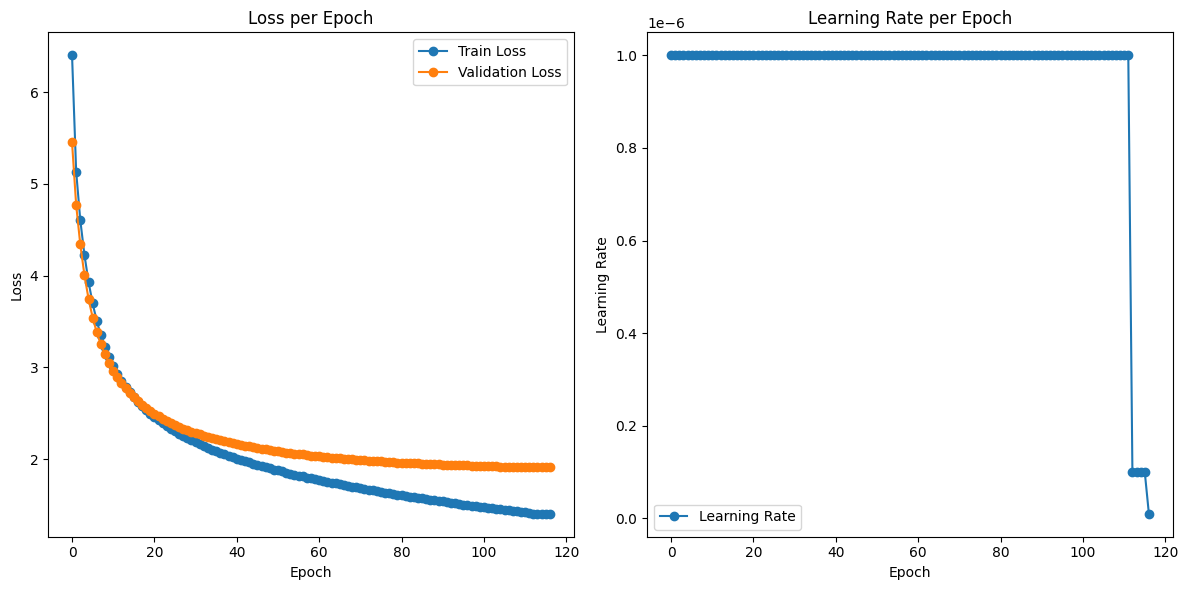

In [62]:
trainer.plot_metrics()

In [63]:
model_inference = torch.load('/kaggle/working/BestModel.pth')
model_inference = model_inference.to(device)
model_inference.eval()  

start = word_to_idx['<start>']
end = word_to_idx['<end>']
pad = word_to_idx['<pad>']
print(start, end, pad)

<ipython-input-63-d1ecbc211066>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_inference = torch.load('/kaggle/working/BestModel.pth')


1 2 0


# Generate caption

In [64]:
test_img_emb = pd.read_pickle('/kaggle/working/test_img_emb.pkl')

In [65]:
!pip install pycocoevalcap

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.4 MB/s eta 0:00:00


In [66]:
import random
import random
import warnings
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.spice.spice import Spice

In [67]:
def gen_caption(k, image_name):
    img = Image.open(image_name)

    if image_name not in test_img_emb:
        print(f"Image embedding not found for {image_name}")
        return []

    img_emb = test_img_emb[image_name]  # (1, 512, 7, 7)
    img_emb = img_emb.permute(0, 2, 3, 1)  # (1, 7, 7, 512)
    img_emb = img_emb.reshape(img_emb.size(0), -1, img_emb.size(3))

    caption = []
    seq = [pad] * max_sequence_len
    seq[0] = start
    seq = torch.tensor(seq).unsqueeze(0).to(device)
    img_emb = img_emb.to(device)

    for i in range(0, max_sequence_len - 1):
        out, _ = model_inference(seq, img_emb)  # (seq_len, batch_size, vocab_size)
        pred = out[i, 0, :]
        indicies = torch.topk(pred, k).indices.tolist()
        values = torch.topk(pred, k).values.tolist()
        token = random.choices(indicies, weights=[max(v, 0) for v in values])[0]
        seq = seq.clone()  # Avoid in-place modification
        seq[:, i + 1] = token

        if token == pad or token == end:
            break
        word = idx_to_word[token]
        caption.append(word)
    return caption

In [68]:
def gen_caption_beam_search(k, beam_width, image_name):
    img = Image.open(image_name)

    if image_name not in test_img_emb:
        print(f"Image embedding not found for {image_name}")
        return []

    img_emb = test_img_emb[image_name]  # (1, 512, 7, 7)
    img_emb = img_emb.permute(0, 2, 3, 1)  # (1, 7, 7, 512)
    img_emb = img_emb.reshape(img_emb.size(0), -1, img_emb.size(3))
    img_emb = img_emb.to(device)

    beams = [([start], 0)]

    for _ in range(max_sequence_len - 1):
        new_beams = []
        for seq, score in beams:
            seq_tensor = torch.tensor(seq + [pad] * (max_sequence_len - len(seq))).unsqueeze(0).to(device)
            out, _ = model_inference(seq_tensor, img_emb)  # (seq_len, batch_size, vocab_size)
            pred = out[len(seq) - 1, 0, :]

            topk_indices = torch.topk(pred, k).indices.tolist()
            topk_values = torch.topk(pred, k).values.tolist()

            for idx, value in zip(topk_indices, topk_values):
                new_seq = seq + [idx]
                new_score = score + value
                new_beams.append((new_seq, new_score))

        new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

        if all(seq[-1] == end for seq, _ in new_beams):
            break

        beams = new_beams

    best_seq, _ = max(beams, key=lambda x: x[1])
    
    caption = [idx_to_word[token] for token in best_seq if token != start and token != pad and token != end]
    return caption


In [69]:
def score(gts_dict, res_dict):
    bleu_score = Bleu(n=4)
    bleu, _ = bleu_score.compute_score(gts=gts_dict, res=res_dict)

    rouge_scorer = Rouge()
    rouge, _ = rouge_scorer.compute_score(gts=gts_dict, res=res_dict)

    cider_scorer = Cider()
    cider, _ = cider_scorer.compute_score(gts=gts_dict, res=res_dict)

    meteor_scorer = Meteor()
    meteor, _ = meteor_scorer.compute_score(gts=gts_dict, res=res_dict)

    spice_scorer = Spice()
    spice, _ = spice_scorer.compute_score(gts=gts_dict, res=res_dict)

    return {"BLEU": bleu, "ROUGE": rouge, "CIDEr": cider, "METEOR": meteor, "SPICE": spice}

In [70]:
gts_dict, ref_dict = {}, {}
dem = 0

In [71]:
with tqdm(total=len(test_unique_image['image']), unit="image") as pbar:
    for image_name in test_unique_image['image']:
        list_real_caption = [' '.join(i.split()[1:-2]) for i in img_path_to_caption_test[image_name]]

        result = gen_caption_beam_search(1, 15, image_name)
        result = ' '.join(result[:-1])
        ref = [i.lower() for i in list_real_caption]

        if len(ref) == 0:
            dem += 1
            print(f"Skipping image {image_name} with no reference captions.")
        else:
            gts_dict[image_name] = ref
            ref_dict[image_name] = [result]
        pbar.update(1)

  0%|          | 0/558 [00:00<?, ?image/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 558/558 [01:00<00:00,  9.23image/s]


In [72]:
scores = score(gts_dict, ref_dict)
print('\n ********** Scores ********** \n', scores)
print('BLEU-4:', scores["BLEU"])
print('ROUGE:', scores["ROUGE"])
print('CIDEr:', scores["CIDEr"])
print('METEOR:', scores["METEOR"])
print('SPICE:', scores["SPICE"])

# testlen: Tổng độ dài (số từ) của tất cả các câu trong tập kết quả dự đoán (generated captions).
# reflen: Tổng độ dài (số từ) của tất cả các câu tham chiếu (ground truth captions).
# guess: Số lượng dự đoán từ (n-grams) mà hệ thống đã cố gắng tạo ra ở các cấp độ khác nhau (1-gram, 2-gram, 3-gram, 4-gram). 1-gram: guess[0] = 3286 2-gram: guess[1] = 2728 3-gram: guess[2] = 2170 4-gram: guess[3] = 1612
# correct: Số lượng từ (n-grams) dự đoán chính xác so với câu tham chiếu 1-gram: correct[0] = 2039 2-gram: correct[1] = 806 3-gram: correct[2] = 131 4-gram: correct[3] = 9

{'testlen': 5732, 'reflen': 5869, 'guess': [5732, 5174, 4616, 4058], 'correct': [3593, 1835, 867, 468]}
ratio: 0.9766570114157477
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.

 ********** Scores ********** 
 {'BLEU': [0.6120275941397564, 0.46036288998703373, 0.3387333523485069, 0.2572064852354028], 'ROUGE': 0.4894928872599561, 'CIDEr': 0.6282327864812782, 'METEOR': 0.299501984218681, 'SPICE': 0.07818030382887628}
BLEU-4: [0.6120275941397564, 0.46036288998703373, 0.3387333523485069, 0.2572064852354028]
ROUGE: 0.4894928872599561
CIDEr: 0.6282327864812782
METEOR: 0.299501984218681
SPICE: 0.07818030382887628
